In [6]:
import sys
sys.path.insert(1,'../../')
import qtrajectories as qtr

import matplotlib.pyplot as plt
import numpy as np

from numba import njit

In [7]:
from tqdm import tqdm

## Steering calculation

In [8]:
def steering(X_ensemble, Y_ensemble):
    if np.shape(X_ensemble)[0] != np.shape(Y_ensemble)[0]:
        raise ValueError('Both ensembles have a diffrent number of trajectories')
    
    ## number of trajectories
    n_trajectories = np.shape(X_ensemble)[0]
    
    ## Expectation values 
    EX, EY, EXII, EYII, SII = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))

    ## X Trajectories ensemble
    for X_traj in X_ensemble:
        X_bloch = qtr.misc.rhoBlochrep_data(X_traj)
        for i in range(len(t)):
            EXII[i] += X_bloch[2][i]**2
            EX[i] += X_bloch[0][i]**2 + X_bloch[1][i]**2
    ## Y Trajectories ensemble
    for Y_traj in Y_ensemble:
        Y_bloch = qtr.misc.rhoBlochrep_data(Y_traj)
        for i in range(len(t)):
            EYII[i] += Y_bloch[0][i]**2 + Y_bloch[1][i]**2
            EY[i] += Y_bloch[0][i]**2 + Y_bloch[1][i]**2
    
    EX, EY, EXII, EYII = EX/n_trajectories, EY/n_trajectories, EXII/n_trajectories, EYII/n_trajectories

    #FIG 4
    for i in range(len(t)):
        SII[i] = EYII[i] + EXII[i]

    return SII, EX, EY

## System details

In [9]:
###SYSTEM
## Parameters 
gamma = 1

## Initial state 
psi0 = 1/np.sqrt(2) * np.array([1.,1.], dtype=np.complex128)
rho0 = np.asarray(np.transpose(np.asmatrix(psi0)).dot(np.conjugate(np.asmatrix(psi0)))) 

## Hamiltonian
H0 = np.zeros((2,2), dtype=np.complex128)

## Lindblad operators
L = np.array([np.sqrt(gamma)*qtr.sigmaz], dtype=np.complex128)

## Diffusive limit

In [15]:
%%time

## time span
t0 = 0.
tf = 10
time_steps = 1000
dt = abs(tf-t0)/time_steps
t = np.linspace(t0, tf, time_steps)

## efficiencies
eta0 = 0.1
etaf = 0.9
eta_vec = np.linspace(eta0, etaf, num = 9)

## number of trajectories
n_trajectories = 1000

## Class objects
## Unraveling details
nu = eta0
u_1 = nu * np.eye(1)   #X-homodyne
u_2 = -1* nu * np.eye(1)  #Y-homodyne
h = eta0 * np.eye(1)
systemX = qtr.System(H0, rho0, t, lindbladList = L, uMatrix = u_1, HMatrix = h)
systemY = qtr.System(H0, rho0, t, lindbladList = L, uMatrix = u_2, HMatrix = h)
    
SII_eta = []
for eta in tqdm(eta_vec):
    ## Unraveling details
    nu = eta
    u_1 = nu * np.eye(1)   #X-homodyne
    u_2 = -1* nu * np.eye(1)  #Y-homodyne
    h = eta * np.eye(1)

    systemX.update_representation(uMatrix=u_1, HMatrix=h)
    systemY.update_representation(uMatrix=u_2, HMatrix=h)
       
    ## X Trajectories ensemble
    X_ensemble = systemX.diffusiveRhoEnsemble(n_trajectories) 
    
    ## Y Trajectories ensemble
    Y_ensemble = systemY.diffusiveRhoEnsemble(n_trajectories)
    
    SII, EX, EY = steering(X_ensemble, Y_ensemble)
    SII_eta.append(SII)
    
np.save(f'data_diffusive.npy', np.array([t, eta_vec, SII_eta], dtype = object))

100%|██████████| 9/9 [02:16<00:00, 15.20s/it]

CPU times: user 1min 37s, sys: 5.83 s, total: 1min 43s
Wall time: 2min 16s


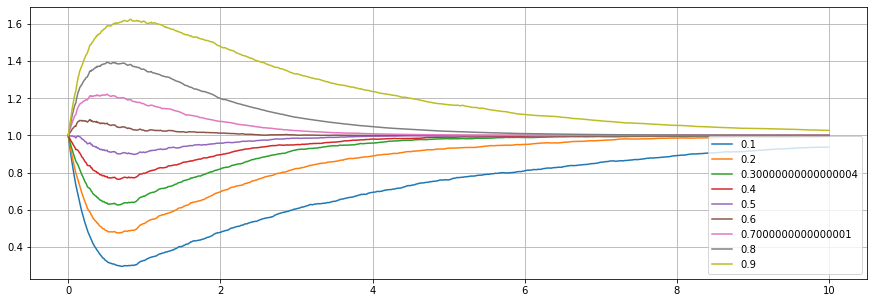

In [16]:
data = np.load(f'data_diffusive.npy', allow_pickle=True)

plt.rcParams['figure.figsize'] = [15,5]
for n_eta, eta in enumerate(data[1]):
    plt.plot(data[0], data[2][n_eta], label = eta)
plt.grid()
plt.legend()

In [49]:
## time span
t0 = 0.
tf = 10
time_steps = 7000
dt = abs(tf-t0)/time_steps
t = np.linspace(t0, tf, time_steps)

## Unraveling details
eta = 0.6
nu = eta
u_1 = nu * np.eye(1)   #X-homodyne
u_2 = -1* nu * np.eye(1)  #Y-homodyne
h = eta * np.eye(1)

## Class objects
systemX = qtr.System(H0, rho0, t, lindbladList = L, uMatrix = u_1, HMatrix = h)
systemY = qtr.System(H0, rho0, t, lindbladList = L, uMatrix = u_2, HMatrix = h)

In [50]:
%%time
n_trajectories = 4000
N = 3
Mu_vec =  np.linspace(0.3,1,N)

SII_vec = []
for mu in tqdm(Mu_vec):
    ## Amplitudes
    coherent_fields_X = np.array([mu,0], dtype=np.complex128)
    coherent_fields_Y = np.array([0,mu], dtype=np.complex128)
    
    ## X Trajectories ensemble
    X_ensemble = systemX.jumpRhoEnsemble(n_trajectories, coherent_fields=coherent_fields_X) 
    
    ## Y Trajectories ensemble
    Y_ensemble = systemY.jumpRhoEnsemble(n_trajectories, coherent_fields=coherent_fields_X)
    
    SII, EX, EY = steering(X_ensemble, Y_ensemble)
    SII_vec.append(SII)
    
np.save(f'data_eta_{eta}.npy', np.array([t, Mu_vec, SII_vec], dtype = object))

100%|██████████| 3/3 [21:41<00:00, 433.79s/it]

CPU times: user 13min 42s, sys: 39 s, total: 14min 20s
Wall time: 21min 41s


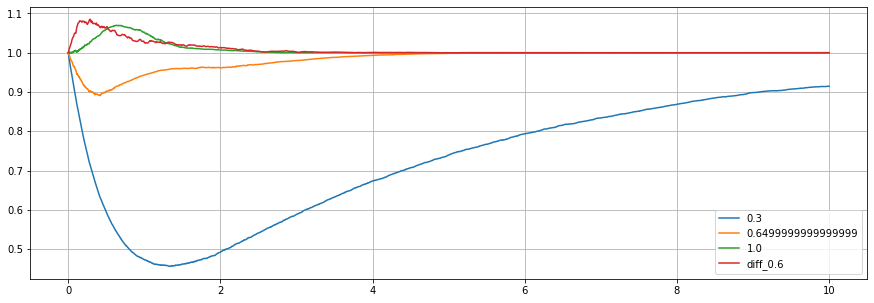

In [57]:
data = np.load(f'data_eta_{eta}.npy', allow_pickle=True)
data_diff = np.load(f'data_diffusive.npy', allow_pickle=True)

plt.rcParams['figure.figsize'] = [15,5]
for n_mu, mu in enumerate(data[1]):
    plt.plot(data[0], data[2][n_mu], label = mu)
plt.plot(data_diff[0], data_diff[2][5], label = 'diff_0.6')

plt.grid()
plt.legend()